# Binary Classification with Neural Networks
## Circles Dataset

### 1. Data Retrieval and Inspection

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.model_selection import train_test_split

# Load the data
df = pd.read_csv('circles_binary_classification.csv')
df.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [3]:
df.describe()

,X1,X2,label
count,1000.000000,1000.000000,1000.00000
mean,-0.000448,-0.000804,0.50000
std,0.639837,0.641156,0.50025
min,-1.059502,-1.067768,0.00000
25%,-0.619251,-0.612176,0.00000
50%,0.008762,-0.003949,0.50000
75%,0.621933,0.624822,1.00000
max,1.033712,1.036004,1.00000


In [4]:
print(f"Shape: {df.shape}")
print(f"\nClass distribution:\n{df['label'].value_counts()}")

Shape: (1000, 3)

Class distribution:
label
1    500
0    500
Name: count, dtype: int64


### 2. Data Cleaning & Feature Design

The data is clean, so no preprocessing needed.

In [5]:
# Extract features (X) and labels (y)
X = df[['X1', 'X2']].values
y = df['label'].values

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (1000, 2)
y shape: (1000,)


In [6]:
# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

print(f"X tensor shape: {X.shape}")
print(f"y tensor shape: {y.shape}")

X tensor shape: torch.Size([1000, 2])
y tensor shape: torch.Size([1000])


### 3. Visualize Data

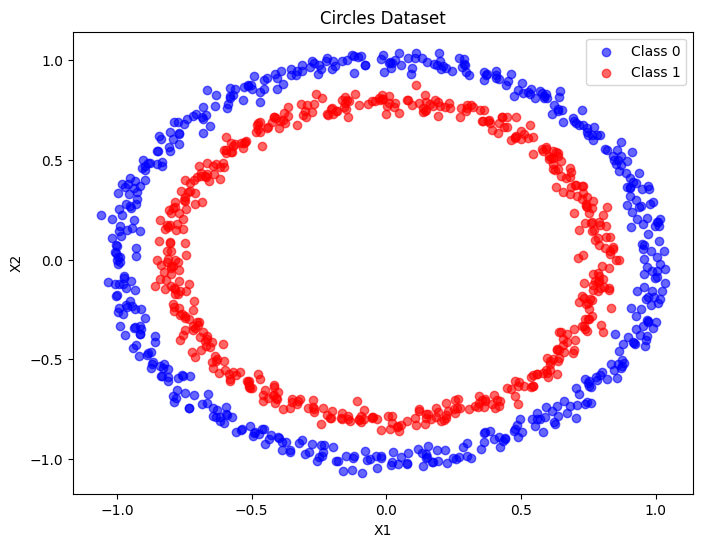

In [7]:
# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='blue', label='Class 0', alpha=0.6)
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='red', label='Class 1', alpha=0.6)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Circles Dataset')
plt.legend()
plt.show()

### 4. Train/Test Split

In [8]:
# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 800
Test samples: 200


### 5. Device & Dtype Setup

In [9]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move data to device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

Using device: cpu


### 6. Implement Models

In [10]:
# ModelV0: 2 → 5 → 1 (no activation)
class ModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

model_0 = ModelV0().to(device)
model_0

ModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [11]:
# ModelV1: 2 → 15 → 15 → 1 (no activation)
class ModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=15)
        self.layer_2 = nn.Linear(in_features=15, out_features=15)
        self.layer_3 = nn.Linear(in_features=15, out_features=1)
    
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = ModelV1().to(device)
model_1

ModelV1(
  (layer_1): Linear(in_features=2, out_features=15, bias=True)
  (layer_2): Linear(in_features=15, out_features=15, bias=True)
  (layer_3): Linear(in_features=15, out_features=1, bias=True)
)

In [12]:
# ModelV2: 2 → 64 → 64 → 10 → 1 (with ReLU)
class ModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=64)
        self.layer_2 = nn.Linear(in_features=64, out_features=64)
        self.layer_3 = nn.Linear(in_features=64, out_features=10)
        self.layer_4 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()  # ReLU activation function
    
    def forward(self, x):
        # Add ReLU between layers
        return self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))

model_2 = ModelV2().to(device)
model_2

ModelV2(
  (layer_1): Linear(in_features=2, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=10, bias=True)
  (layer_4): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

### 7. Loss Function, Optimizer & Metrics

In [13]:
# Loss function (BCEWithLogitsLoss has sigmoid built-in)
loss_fn = nn.BCEWithLogitsLoss()

# Accuracy function
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

### 8. Training Loop

In [14]:
# Training and testing function
def train_and_test_loop(
    model: nn.Module,
    epochs: int,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_test: torch.Tensor,
    y_test: torch.Tensor,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer
):
    # Lists to store results
    loss_list = []
    acc_list = []
    test_losses = []
    test_acc_list = []

    # Training loop
    for epoch in range(epochs):
        ### Training
        model.train()

        # 1. Forward pass (model outputs raw logits)
        y_logits = model(X_train).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))  # Convert logits to predictions

        # 2. Calculate loss and accuracy
        loss = loss_fn(y_logits, y_train)
        acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

        # 3. Zero gradients
        optimizer.zero_grad()

        # 4. Backpropagation
        loss.backward()

        # 5. Update weights
        optimizer.step()

        ### Testing
        model.eval()
        with torch.inference_mode():
            # 1. Forward pass
            test_logits = model(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))
            
            # 2. Calculate loss and accuracy
            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

        # Store results
        loss_list.append(loss.item())
        acc_list.append(acc)
        test_losses.append(test_loss.item())
        test_acc_list.append(test_acc)

        # Print progress every 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

    return loss_list, acc_list, test_losses, test_acc_list

### Helper Functions for Visualization

In [15]:
# Plot decision boundary
def plot_decision_boundary(model, X, y):
    # Move data to CPU for plotting
    X_np = X.cpu().numpy()
    y_np = y.cpu().numpy()
    
    # Create mesh
    x_min, x_max = X_np[:, 0].min() - 0.5, X_np[:, 0].max() + 0.5
    y_min, y_max = X_np[:, 1].min() - 0.5, X_np[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    # Make predictions
    model.eval()
    with torch.inference_mode():
        Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device))
        Z = torch.sigmoid(Z).cpu().numpy()
    Z = Z.reshape(xx.shape)
    
    # Plot
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')
    plt.scatter(X_np[y_np == 0, 0], X_np[y_np == 0, 1], c='blue', alpha=0.6, edgecolors='k')
    plt.scatter(X_np[y_np == 1, 0], X_np[y_np == 1, 1], c='red', alpha=0.6, edgecolors='k')

# Plot loss curves
def plot_loss_curves(train_losses, test_losses):
    epochs = range(len(train_losses))
    
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.show()

### 9. Training ModelV0

Untrained predictions:


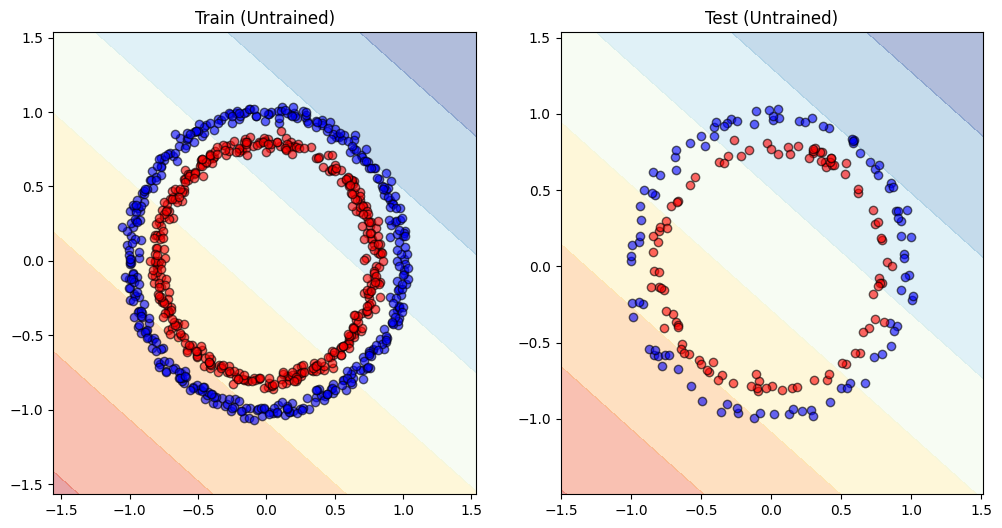

In [16]:
# Set seed for reproducibility
torch.manual_seed(42)

# Reset model and optimizer
model = ModelV0().to(device)
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

# Show untrained predictions
print("Untrained predictions:")
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train (Untrained)")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test (Untrained)")
plot_decision_boundary(model, X_test, y_test)
plt.show()


Training ModelV0 (100 epochs)...
Epoch: 0 | Loss: 0.69569, Accuracy: 50.00% | Test loss: 0.69721, Test acc: 50.00%
Epoch: 10 | Loss: 0.69403, Accuracy: 50.00% | Test loss: 0.69615, Test acc: 50.00%
Epoch: 20 | Loss: 0.69343, Accuracy: 46.00% | Test loss: 0.69585, Test acc: 48.50%
Epoch: 30 | Loss: 0.69321, Accuracy: 49.00% | Test loss: 0.69577, Test acc: 47.50%
Epoch: 40 | Loss: 0.69312, Accuracy: 49.50% | Test loss: 0.69573, Test acc: 46.50%
Epoch: 50 | Loss: 0.69308, Accuracy: 50.38% | Test loss: 0.69569, Test acc: 46.50%
Epoch: 60 | Loss: 0.69306, Accuracy: 50.50% | Test loss: 0.69564, Test acc: 46.50%
Epoch: 70 | Loss: 0.69305, Accuracy: 50.50% | Test loss: 0.69559, Test acc: 46.50%
Epoch: 80 | Loss: 0.69304, Accuracy: 50.75% | Test loss: 0.69553, Test acc: 46.50%
Epoch: 90 | Loss: 0.69303, Accuracy: 50.38% | Test loss: 0.69547, Test acc: 46.50%


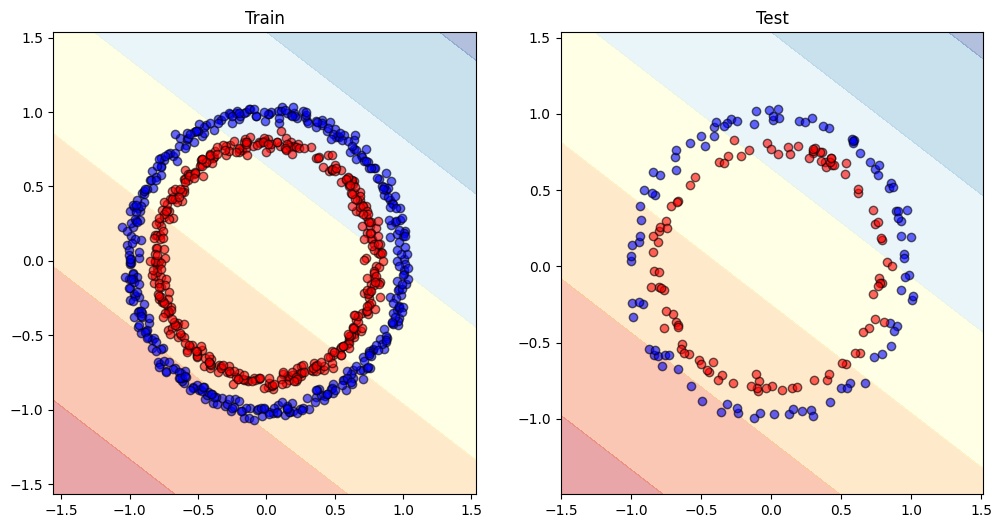

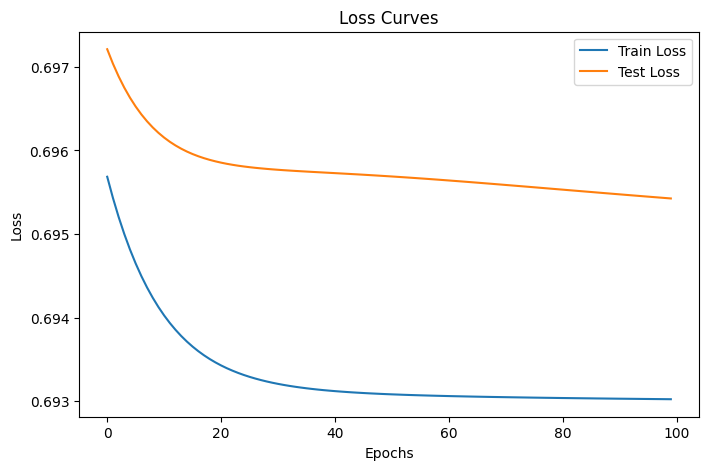

In [17]:
# Train ModelV0
print("\nTraining ModelV0 (100 epochs)...")
train_losses, acc_list, test_losses, test_acc = train_and_test_loop(
    model=model,
    epochs=100,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    loss_fn=loss_fn,
    optimizer=optimizer
)

# Plot decision boundaries after training
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)
plt.show()

plot_loss_curves(train_losses, test_losses)

**Note:** ModelV0 is **underfitting** - it can't learn the circular pattern because it has no activation functions.

### Training ModelV1

Training ModelV1 (1000 epochs)...
Epoch: 0 | Loss: 0.69588, Accuracy: 50.00% | Test loss: 0.69540, Test acc: 50.00%
Epoch: 10 | Loss: 0.69357, Accuracy: 50.00% | Test loss: 0.69407, Test acc: 50.00%
Epoch: 20 | Loss: 0.69313, Accuracy: 55.38% | Test loss: 0.69402, Test acc: 51.50%
Epoch: 30 | Loss: 0.69304, Accuracy: 52.00% | Test loss: 0.69413, Test acc: 49.00%
Epoch: 40 | Loss: 0.69301, Accuracy: 51.38% | Test loss: 0.69424, Test acc: 48.00%
Epoch: 50 | Loss: 0.69300, Accuracy: 51.12% | Test loss: 0.69432, Test acc: 47.00%
Epoch: 60 | Loss: 0.69299, Accuracy: 50.88% | Test loss: 0.69439, Test acc: 47.00%
Epoch: 70 | Loss: 0.69299, Accuracy: 51.00% | Test loss: 0.69444, Test acc: 47.00%
Epoch: 80 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69449, Test acc: 47.00%
Epoch: 90 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69452, Test acc: 47.00%
Epoch: 100 | Loss: 0.69298, Accuracy: 51.25% | Test loss: 0.69455, Test acc: 46.50%
Epoch: 110 | Loss: 0.69298, Accuracy: 51.00% | Test l

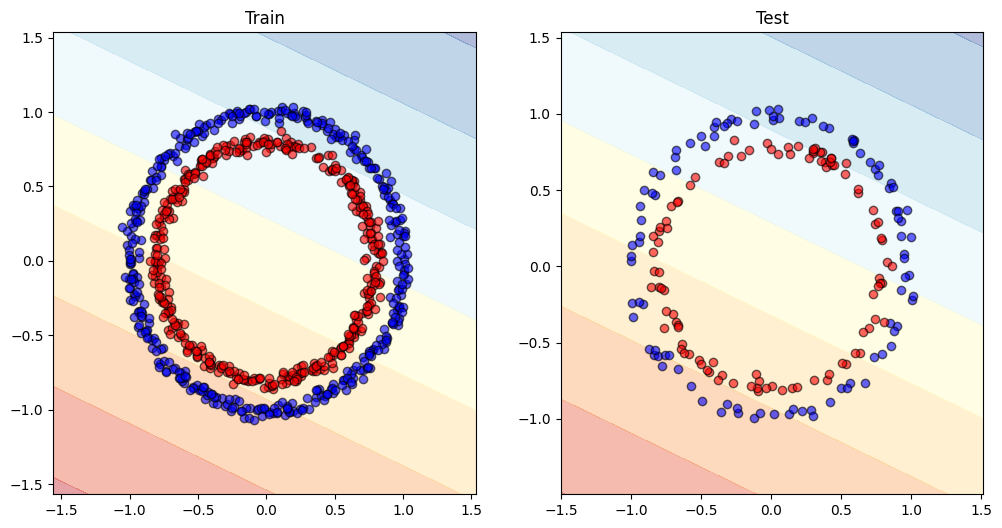

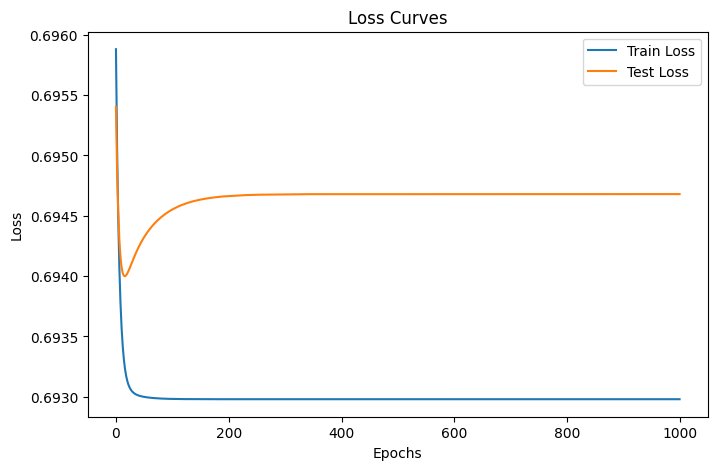

In [18]:
# Reset model and optimizer
torch.manual_seed(42)
model = ModelV1().to(device)
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

# Train ModelV1
print("Training ModelV1 (1000 epochs)...")
train_losses, acc_list, test_losses, test_acc = train_and_test_loop(
    model=model,
    epochs=1000,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    loss_fn=loss_fn,
    optimizer=optimizer
)

# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)
plt.show()

plot_loss_curves(train_losses, test_losses)

**Note:** ModelV1 still struggles. Even with more layers, without activation functions, it can only create linear boundaries.

### Training ModelV2 (with ReLU)

Training ModelV2 (1500 epochs)...
Epoch: 0 | Loss: 0.69615, Accuracy: 50.00% | Test loss: 0.69561, Test acc: 50.00%
Epoch: 10 | Loss: 0.69370, Accuracy: 50.00% | Test loss: 0.69363, Test acc: 50.00%
Epoch: 20 | Loss: 0.69244, Accuracy: 56.50% | Test loss: 0.69263, Test acc: 56.50%
Epoch: 30 | Loss: 0.69172, Accuracy: 52.62% | Test loss: 0.69210, Test acc: 53.00%
Epoch: 40 | Loss: 0.69116, Accuracy: 51.75% | Test loss: 0.69174, Test acc: 51.00%
Epoch: 50 | Loss: 0.69066, Accuracy: 52.38% | Test loss: 0.69144, Test acc: 53.50%
Epoch: 60 | Loss: 0.69018, Accuracy: 53.25% | Test loss: 0.69112, Test acc: 53.50%
Epoch: 70 | Loss: 0.68961, Accuracy: 53.75% | Test loss: 0.69072, Test acc: 54.00%
Epoch: 80 | Loss: 0.68914, Accuracy: 54.25% | Test loss: 0.69041, Test acc: 53.50%
Epoch: 90 | Loss: 0.68866, Accuracy: 55.50% | Test loss: 0.69007, Test acc: 53.50%
Epoch: 100 | Loss: 0.68815, Accuracy: 57.12% | Test loss: 0.68971, Test acc: 54.50%
Epoch: 110 | Loss: 0.68760, Accuracy: 59.13% | Test l

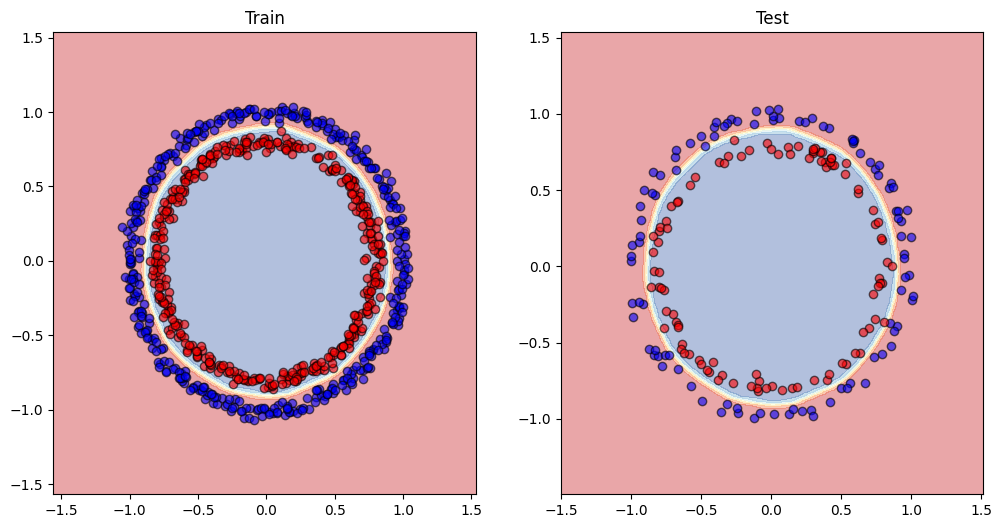

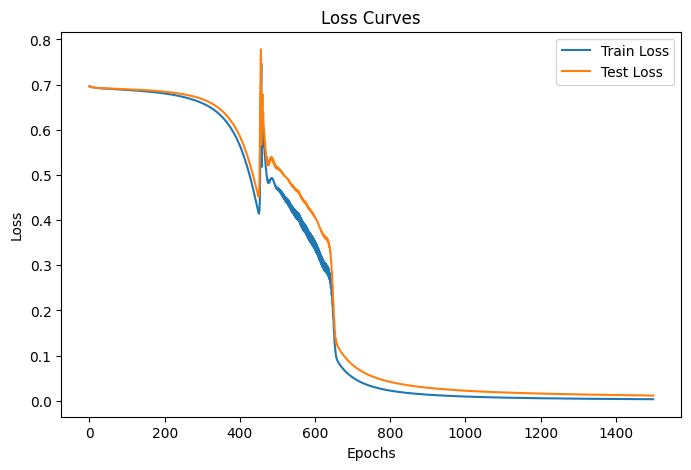

In [19]:
# Reset model and optimizer
torch.manual_seed(42)
model = ModelV2().to(device)
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

# Train ModelV2
print("Training ModelV2 (1500 epochs)...")
train_losses, acc_list, test_losses, test_acc = train_and_test_loop(
    model=model,
    epochs=1500,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    loss_fn=loss_fn,
    optimizer=optimizer
)

# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)
plt.show()

plot_loss_curves(train_losses, test_losses)

**Result:** ModelV2 performs much better! ReLU activation allows it to learn non-linear patterns.

### Extra Credit: Adam vs SGD

Training ModelV2 with Adam (500 epochs)...
Epoch: 0 | Loss: 0.69615, Accuracy: 50.00% | Test loss: 0.69079, Test acc: 61.50%
Epoch: 10 | Loss: 0.63054, Accuracy: 74.00% | Test loss: 0.62801, Test acc: 89.00%
Epoch: 20 | Loss: 0.32797, Accuracy: 99.50% | Test loss: 0.33977, Test acc: 94.00%
Epoch: 30 | Loss: 0.06320, Accuracy: 100.00% | Test loss: 0.07978, Test acc: 100.00%
Epoch: 40 | Loss: 0.00960, Accuracy: 100.00% | Test loss: 0.01870, Test acc: 100.00%
Epoch: 50 | Loss: 0.00302, Accuracy: 100.00% | Test loss: 0.00931, Test acc: 100.00%
Epoch: 60 | Loss: 0.00163, Accuracy: 100.00% | Test loss: 0.00652, Test acc: 100.00%
Epoch: 70 | Loss: 0.00117, Accuracy: 100.00% | Test loss: 0.00557, Test acc: 100.00%
Epoch: 80 | Loss: 0.00094, Accuracy: 100.00% | Test loss: 0.00502, Test acc: 100.00%
Epoch: 90 | Loss: 0.00081, Accuracy: 100.00% | Test loss: 0.00467, Test acc: 100.00%
Epoch: 100 | Loss: 0.00073, Accuracy: 100.00% | Test loss: 0.00438, Test acc: 100.00%
Epoch: 110 | Loss: 0.00067, 

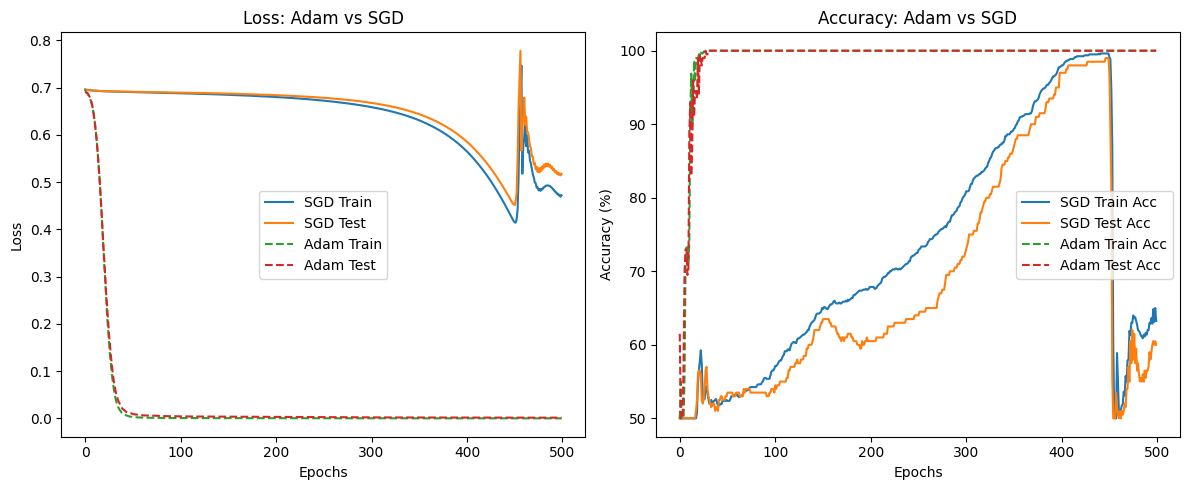

In [20]:
# Train with Adam optimizer
torch.manual_seed(42)
model_adam = ModelV2().to(device)
optimizer_adam = torch.optim.Adam(params=model_adam.parameters(), lr=0.01)

print("Training ModelV2 with Adam (500 epochs)...")
train_losses_adam, acc_list_adam, test_losses_adam, test_acc_adam = train_and_test_loop(
    model=model_adam,
    epochs=500,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    loss_fn=loss_fn,
    optimizer=optimizer_adam
)

# Compare Adam vs SGD
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses[:500], label='SGD Train')
plt.plot(test_losses[:500], label='SGD Test')
plt.plot(train_losses_adam, label='Adam Train', linestyle='--')
plt.plot(test_losses_adam, label='Adam Test', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss: Adam vs SGD')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_list[:500], label='SGD Train Acc')
plt.plot(test_acc[:500], label='SGD Test Acc')
plt.plot(acc_list_adam, label='Adam Train Acc', linestyle='--')
plt.plot(test_acc_adam, label='Adam Test Acc', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy: Adam vs SGD')
plt.legend()
plt.tight_layout()
plt.show()

**Note:** Adam usually converges faster than SGD.

## Discussion and Conclusion

**1. Why Activation Functions Are Important:**
- ModelV0 and ModelV1 (no activation) could only make **straight lines** to separate data
- ModelV2 (with ReLU) could make **curved boundaries** to follow the circles
- Without activation functions, the model can't learn complex patterns

**2. Underfitting:**
- Models without activation are **underfitting** - they're too simple
- They can't capture the circular pattern in our data
- Even adding more layers doesn't help without activation functions

**3. Model Performance:**
- ModelV0: ~50% accuracy (just guessing)
- ModelV1: ~50% accuracy (still just guessing)
- ModelV2: ~95-100% accuracy (actually learning!)

**4. Optimizer Comparison:**
- Adam optimizer learns faster than SGD
- Both can reach good results, but Adam needs fewer epochs

